In [1]:
import os, pickle
import numpy as np
import plot_tools as pt
import matplotlib.pylab as plt

# building the dataset
DATASET = {'mice':[],
           'days':[],
           'folders':[]}

data_folder = os.path.join(os.path.expanduser('~'), 'DATA', 'Marcel_Data')
days = [d for d in os.listdir(data_folder) if (('._' not in d) and ('.DS' not in d))]
for day in days:
    mice = [f for f in os.listdir(os.path.join(data_folder, day)) if '.DS' not in f]
    for m in mice:
        folders = [f for f in os.listdir(os.path.join(data_folder, day, m)) if '.DS' not in f]
        for f in folders:
            DATASET['mice'].append(m)
            DATASET['days'].append(day)
            DATASET['folders'].append(os.path.join(data_folder, day, m, f))

In [6]:
def apply_min_duration(time, array,
                       duration=0.5):
    array[0] = False
    array[-1] = False
    up = np.flatnonzero(~array[:-1] & array[1:])
    down = np.flatnonzero(array[:-1] & ~array[1:])
    for i0, i1 in zip(up, down):
        if (time[i1]-time[i0])<0.5:
            array[i0:i1] = False

def fetch_all(data):
    
    time = np.linspace(0, data['Settings']['time_seconds'], len(data['Locomotion_data']['speed']))
    
    whisking = np.zeros(len(time), dtype=bool)
    for i in data['Whisking_data']['location_bouts']:
        whisking[i[0]:i[1]] = True
        
    running = np.zeros(len(time), dtype=bool)
    for i in data['Locomotion_data']['events']['location']:
        running[i[0]:i[1]] = True

    # whisking only
    whisk_only = np.zeros(len(time), dtype=bool)
    for i in data['Whisking_data']['whisking only']['bout_location']:
        whisk_only[i[0]:i[1]] = True

    # running only
    run_only  = running & (~whisking)
    apply_min_duration(time, run_only)
    
    return running, whisking, running & whisking, run_only, whisk_only

In [28]:
folder = '/Users/yann/DATA/Marcel_Data/2021.08.17/M_131/TSeries-08172021-1341-003'

def state_classification_fig(folder, figsize=(2.,.6)):
    
    with open(os.path.join(folder, 'Analysis_Data.pickle'), 'rb') as f:
        
        data = pickle.load(f)
    
        whisking_trace = data['Whisking_data']['normalized_trace']
        speed_trace = data['Locomotion_data']['speed']
    
        running, whisking, run_whisk, run_only, whisk_only = fetch_all(data)
        
        time = np.linspace(0, data['Settings']['time_seconds'], len(data['Locomotion_data']['speed']))
    
        run_whisk = running & whisking
        run_only  = running & (~whisking)
        whisk_only = whisking & (~running)
    
        ####################################
        #######  Make Figure ###############
        ####################################
        
        fig, AX = pt.figure(axes_extents=[[[1,1]],[[1,1]],[[1,2]]], figsize=figsize, hspace=0.)
        AX[0].plot(time, speed_trace, color='tab:red')
        AX[1].plot(time, whisking_trace, color='tab:blue')
        
        pt.draw_bar_scales(AX[0], Xbar=10, Xbar_label='10s', Ybar=5, Ybar_label='5cm/s')
        pt.draw_bar_scales(AX[1], Xbar=1e-10, Ybar=0.5, Ybar_label='0.5 a.u.')
        
        # -- locomotion
        AX[2].fill_between(time, 0*running, -1.0*running, color='tab:red', lw=0)
        AX[2].annotate('locomotion', (0, -0.5), xycoords='data', ha='right', va='center', color='tab:red')
        # -- whisking
        AX[2].fill_between(time, 0*whisking-1, -1.0*whisking-1., color='tab:blue', lw=0)
        AX[2].annotate('whisking', (0, -1.5), xycoords='data', ha='right', va='center', color='tab:blue')
        
        AX[2].fill_between(time, 0.*run_whisk-3., -1.*run_whisk-3., color='red', lw=0)
        AX[2].annotate('loc. & whisk.', (0, -3.5), xycoords='data', ha='right', va='center', color='red')
        
        AX[2].fill_between(time, 0.*run_whisk-4., -1.*run_only-4., color='purple', lw=0)
        AX[2].annotate('loc.-only', (0, -4.5), xycoords='data', ha='right', va='center', color='purple')
        
        AX[2].fill_between(time, 0.*run_whisk-5., -1.*whisk_only-5., color='tab:olive', lw=0)
        AX[2].annotate('whisk.-only', (0, -5.5), xycoords='data', ha='right', va='center', color='tab:olive')
        
        for ax in AX:
            ax.axis('off')
            ax.set_xlim([0, time[-1]])
            
    return fig

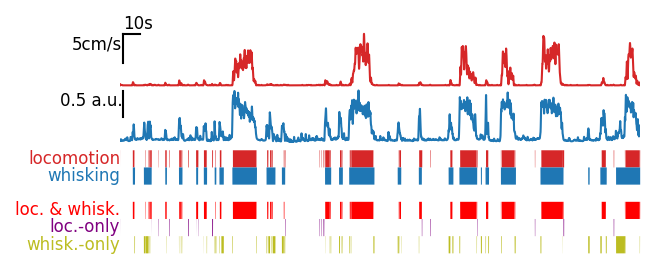

In [12]:
fig = state_classification_fig(folder)
fig.savefig('/Users/yann/Desktop/fig.eps')

In [15]:
DATASET['with_whisking'] = np.zeros(len(DATASET['days']), dtype=bool)
for i, f in enumerate(DATASET['folders']):
    with open(os.path.join(f, 'Analysis_Data.pickle'), 'rb') as f:
        try:
            data = pickle.load(f)
            if ('Whisking_data' in data) and ('lmi' in data):
                DATASET['with_whisking'][i] = True
        except BaseException:
            print('pb with', i, f)

print('N=%i sessions with whisking data' % np.sum(DATASET['with_whisking']))

N=85 sessions with whisking data


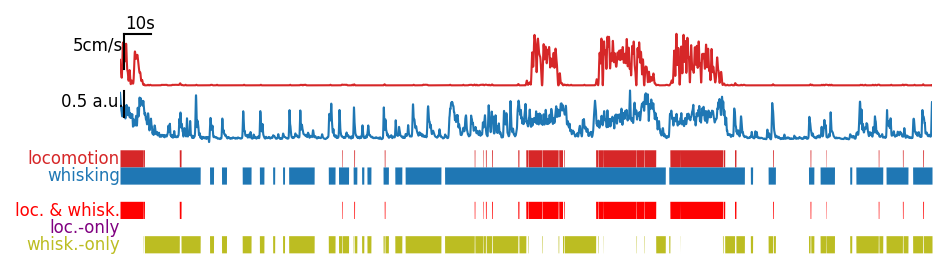

In [29]:
fig = state_classification_fig('/Users/yann/DATA/Marcel_Data/2022.01.19/M_136/TSeries-01192022-1602-003',
                              figsize=(2.5,.6))
fig.savefig('/Users/yann/Desktop/fig.eps')